In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import tensorflow as tf
import matplotlib.pyplot as plt
import nibabel as nib
import os
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import torch



In [2]:
print(torch.__version__)

2.2.2+cpu


In [3]:
#This block for playing with Excel Data
df = pd.read_excel("PTs_500_4k_blinded.xlsx")
df.head()
print(df.info)

del_indices = set() #To keep in track with the deleted values
# Filter out rows with negative values
#This is means that we do have (171-163+1 negative values)
negative_values_filter = (df.iloc[:, 1] < 0) | (df.iloc[:, 2] < 0)
df_filtered = df[~negative_values_filter]
del_indices.update(df[negative_values_filter].index)

#getting red of the outliers
#This is means that we do have 1 outlier
Z_scores = stats.zscore(df_filtered.iloc[:,1])
threshold = 3
outliers_filter = Z_scores >= threshold
df_without_outliers = df_filtered[~outliers_filter]
del_indices.update(df_filtered[outliers_filter].index)
print(df_without_outliers.info)

#Our final preprocessed data is df_without_outliers
# To keep track of the deleted indices, to delete the associated photos as well
print(del_indices)


<bound method DataFrame.info of              ID  PT500  PT4000
0    smwp1_0001   25.0    72.5
1    smwp1_0002    5.0    10.0
2    smwp1_0003    5.0    45.0
3    smwp1_0004    5.0    15.0
4    smwp1_0005    2.5    62.5
..          ...    ...     ...
166  smwp1_0167    0.0    27.5
167  smwp1_0168   37.5     2.5
168  smwp1_0169    7.5    10.0
169  smwp1_0170    0.0    -2.5
170  smwp1_0171   10.0    57.5

[171 rows x 3 columns]>
<bound method DataFrame.info of              ID  PT500  PT4000
0    smwp1_0001   25.0    72.5
1    smwp1_0002    5.0    10.0
2    smwp1_0003    5.0    45.0
3    smwp1_0004    5.0    15.0
4    smwp1_0005    2.5    62.5
..          ...    ...     ...
165  smwp1_0166    2.5     2.5
166  smwp1_0167    0.0    27.5
167  smwp1_0168   37.5     2.5
168  smwp1_0169    7.5    10.0
170  smwp1_0171   10.0    57.5

[162 rows x 3 columns]>
{104, 169, 51, 19, 85, 118, 23, 57, 26}


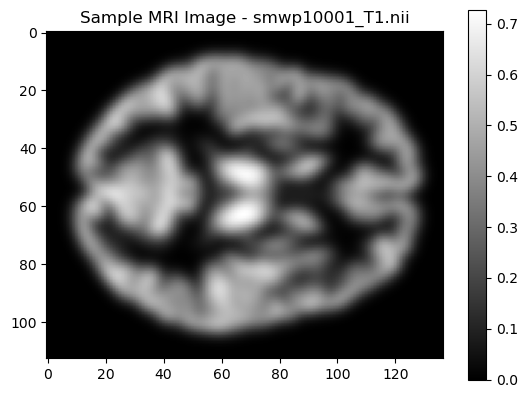

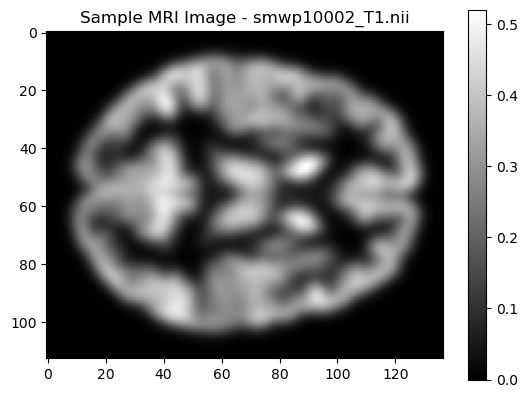

162


In [4]:
#Playing with images, accumulate their data in one matrix
import os
import nibabel as nib

dir = r'\Users\Mohammad\Downloads\DM Project\n171_smwp1'

nii_data = []
Img_count = 0

for file in os.listdir(dir):
    if file.endswith('.nii'):
        filepath = os.path.join(dir, file)
        img = nib.load(filepath)
        data = img.get_fdata()
        nii_data.append(data)
        if Img_count < 2:
            plt.imshow(data[:, :, data.shape[2] // 2], cmap='gray')  # Display a slice from the middle of the image
            plt.title(f'Sample MRI Image - {file}')
            plt.colorbar()
            plt.show()
            Img_count+=1
        
print(len(nii_data))
nii_data_array = np.array(nii_data)

In [12]:
#The shape of our image array
print(nii_data_array.shape)


(162, 113, 137, 113)


In [14]:
count = 0
for idx, image_data in enumerate(nii_data, start=1):
    if count<4:
        print(f"Image {idx}:")
        print(f"Shape: {image_data.shape}")
        print(f"Data type: {image_data.dtype}")
        print(f"Min intensity: {image_data.min()}")
        print(f"Max intensity: {image_data.max()}")
        print()
        count+=1
        

Image 1:
Shape: (113, 137, 113)
Data type: float64
Min intensity: 0.0
Max intensity: 0.8594383597373962

Image 2:
Shape: (113, 137, 113)
Data type: float64
Min intensity: 0.0
Max intensity: 0.6149454712867737

Image 3:
Shape: (113, 137, 113)
Data type: float64
Min intensity: 0.0
Max intensity: 0.7013458013534546

Image 4:
Shape: (113, 137, 113)
Data type: float64
Min intensity: 0.0
Max intensity: 0.6343386769294739



In [5]:
#Normalize the image data to be between Zero and 1
#before normalization
print(f'Max Before Normalization: {nii_data_array.max()}')
#After Normalization
nii_data_reshaped = nii_data_array.reshape(-1,nii_data_array.shape[-1])
scaler = MinMaxScaler()
nii_data_normalized = scaler.fit_transform(nii_data_reshaped)
nii_data_normalized = nii_data_normalized.reshape(nii_data_array.shape)
print(f'Max After Normalization: {nii_data_normalized.max()}')


Max Before Normalization: 1.1022199392318726
Max After Normalization: 1.0


In [6]:
#Spliting the data into training, validation, and testing sets:
X = nii_data_normalized # Image Data
y = df_without_outliers[['PT500','PT4000']].values #Threeshold Data

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=42)
X_train, X_eval, y_train,y_eval = train_test_split(X,y,test_size=0.1,random_state=42)


In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(), #conversion from multidimensional into 1D
    Dense(128, activation='relu'),
    Dense(2)  # 2 output neurons for predicting two hearing thresholds
])

# Compilation
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_eval, y_eval), epochs=20, batch_size=32)

# Evaluate the model on test data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)



C:\Users\Mohammad\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 631.9455 - val_loss: 441.9636
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 930ms/step - loss: 325.3136 - val_loss: 319.6429
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 292.4516 - val_loss: 348.7659
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 290.3585 - val_loss: 336.2483
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 267.3489 - val_loss: 349.0825
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 264.1286 - val_loss: 314.8155
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 285.6200 - val_loss: 362.4553
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 267.8311 - val_loss: 327.9029
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 261.0332 - val_loss: 324.0078
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 272.0106 - val_loss: 342.5661
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 256.4256 - val_loss: 330.4480
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 285

C:\Users\Mohammad\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 486.6999 - val_loss: 967.3853
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - loss: 287.9391 - val_loss: 956.1309
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 264.9137 - val_loss: 933.1948
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - loss: 257.2079 - val_loss: 912.5794
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - loss: 296.2630 - val_loss: 881.1862
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - loss: 260.5003 - val_loss: 851.1954
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - loss: 229.3402 - val_loss: 818.2556
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - loss: 240.9093 - val_loss: 804.2654
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 240.3567 - val_loss: 775.1212
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - loss: 219.1241 - val_loss: 748.1232
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - loss: 216.5463 - val_loss: 733.1210
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - l

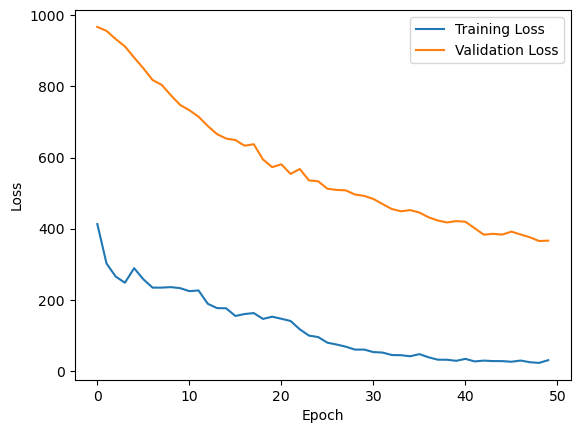

In [16]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Adjusted Model Architecture with Regularization and Batch Normalization
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout for regularization
    Dense(256, activation='relu'),
    Dense(2)  # 2 output neurons for predicting two hearing thresholds
])

# Compile the model with Adam optimizer and learning rate adjustment
optimizer = Adam(learning_rate=0.0001)  # Adjust learning rate as needed
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_eval, y_eval), epochs=50, batch_size=32, verbose=1, callbacks=[EarlyStopping(patience=5)])

# Evaluate the model on test data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Plot training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
